In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import os
import zipfile

import IPython.display as display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
create_model = True
generate_csv = True

# Load and process data

In [ ]:
csv_directory = "./drive/My Drive/Colab Notebooks"
zip_name = "dataset_mask_output"

if generate_csv:
  # unzip dataset

  with zipfile.ZipFile("./drive/My Drive/Colab Notebooks/{}.zip".format(zip_name), 'r') as zip_ref:
    zip_ref.extractall(".")

  # generate and prepare csv for training and validation
  source = [str(i) + ".jpg" for i in range(len(os.listdir("{}/x/".format(zip_name))))]
  dataset = pd.DataFrame(source)

  training_data, validation_data = train_test_split(dataset, test_size=0.1)
  training_data = training_data.sample(frac=1).reset_index(drop=True)
  validation_data = validation_data.sample(frac=1).reset_index(drop=True)
  training_data.to_csv("{}/segmentation_training.csv".format(csv_directory), index=False)
  validation_data.to_csv("{}/segmentation_validation.csv".format(csv_directory), index=False)
else:
  training_data = pd.read_csv("{}/segmentation_training.csv".format(csv_directory))
  validation_data = pd.read_csv("{}/segmentation_validation.csv".format(csv_directory))

print("training data size = {}".format(len(training_data)))
print("validation data size = {}".format(len(validation_data)))

training data size = 2677
validation data size = 298


In [ ]:
@tf.function
def load_image(dir_prefix, row):
  img = matplotlib.image.imread(dir_prefix + row[0])
  return tf.convert_to_tensor(img, dtype=tf.float32) / 255.0

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch_indices = [self.indices[k] for k in index]
        X, Y = self.__get_data(batch_indices)
        return X, Y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch_indices):
        batch = self.df.iloc[batch_indices,:]
        batch["x"] = batch.apply(lambda row: load_image("{}/x/".format(zip_name), row), axis=1)
        batch["y"] = batch.apply(lambda row: load_image("{}/y/".format(zip_name), row), axis=1)
        X = tf.convert_to_tensor(batch["x"].tolist())
        Y = tf.convert_to_tensor(batch["y"].tolist())
        return X, Y


In [ ]:
train_dataset = DataGenerator(training_data)
val_dataset = DataGenerator(validation_data)

# Model

**Create model**

In [ ]:
OUTPUT_CHANNELS = 3

if create_model:
  base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 112x112
      'block_3_expand_relu',   # 56x56
      'block_6_expand_relu',   # 28x28
      'block_13_expand_relu',  # 14x14
      'block_16_project',      # 7x7
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

  down_stack.trainable = False

  up_stack = [
      pix2pix.upsample(896, 3),  # 7x7 -> 14x14
      pix2pix.upsample(448, 3),  # 14x14 -> 28x28
      pix2pix.upsample(224, 3),  # 28x28 -> 56x56
      pix2pix.upsample(112, 3),   # 56x56 -> 112x112
  ]

  def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same') #, activation=tf.keras.activations.sigmoid)  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    
  model = unet_model(OUTPUT_CHANNELS)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

**Load model**

In [ ]:
if not create_model:
  model = tf.keras.models.load_model("./drive/My Drive/Colab Notebooks/seg.hdf5")
  
tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            [(None, 112, 112, 96 1841984     input_5[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 14, 14, 896)  2584064     model_3[0][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 14, 14, 1472) 0           sequential_8[0][0]               
                                                                 model_3[0][3]              

# Training

In [ ]:
tf.config.run_functions_eagerly(True)
model.fit(train_dataset, validation_data=val_dataset, epochs=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even th

Epoch 1/30
83/83 [==============================] - 70s 823ms/step - loss: 0.2410 - accuracy: 0.3309 - val_loss: 0.0373 - val_accuracy: 0.3890
Epoch 2/30
83/83 [==============================] - 69s 832ms/step - loss: 0.0182 - accuracy: 0.3569 - val_loss: 0.0142 - val_accuracy: 0.2820
Epoch 3/30
83/83 [==============================] - 69s 834ms/step - loss: 0.0106 - accuracy: 0.3586 - val_loss: 0.0094 - val_accuracy: 0.2798
Epoch 4/30
83/83 [==============================] - 70s 845ms/step - loss: 0.0078 - accuracy: 0.3576 - val_loss: 0.0070 - val_accuracy: 0.3004
Epoch 5/30
83/83 [==============================] - 70s 841ms/step - loss: 0.0062 - accuracy: 0.3710 - val_loss: 0.0058 - val_accuracy: 0.4370
Epoch 6/30
83/83 [==============================] - 70s 841ms/step - loss: 0.0053 - accuracy: 0.3768 - val_loss: 0.0052 - val_accuracy: 0.3460
Epoch 7/30
83/83 [==============================] - 70s 843ms/step - loss: 0.0047 - accuracy: 0.3815 - val_loss: 0.0048 - val_accuracy: 0.3108

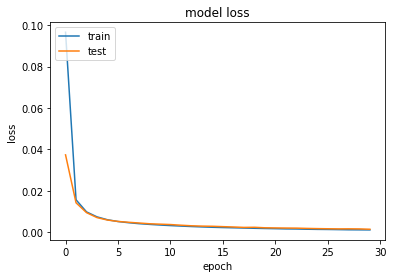

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Network's inference visualisation




**Input image**

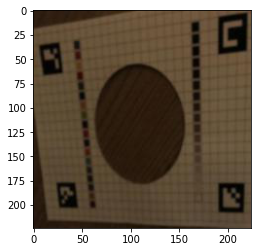

In [ ]:
plt.imshow(matplotlib.image.imread('dataset_mask_output/x/{}'.format(validation_data[0][0])))

**Expected mask**

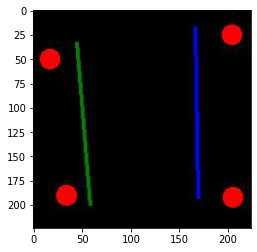

In [ ]:
plt.imshow(matplotlib.image.imread('dataset_mask_output/y/{}'.format(validation_data[0][0])))

**Output image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


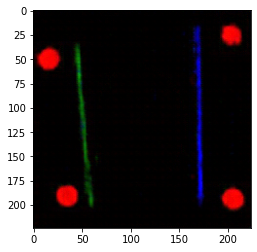

In [ ]:
img = load_image('dataset_mask_output/x/', [validation_data[0][0]])
mask = model(tf.convert_to_tensor([img]))
plt.imshow(mask[0,:,:,:])

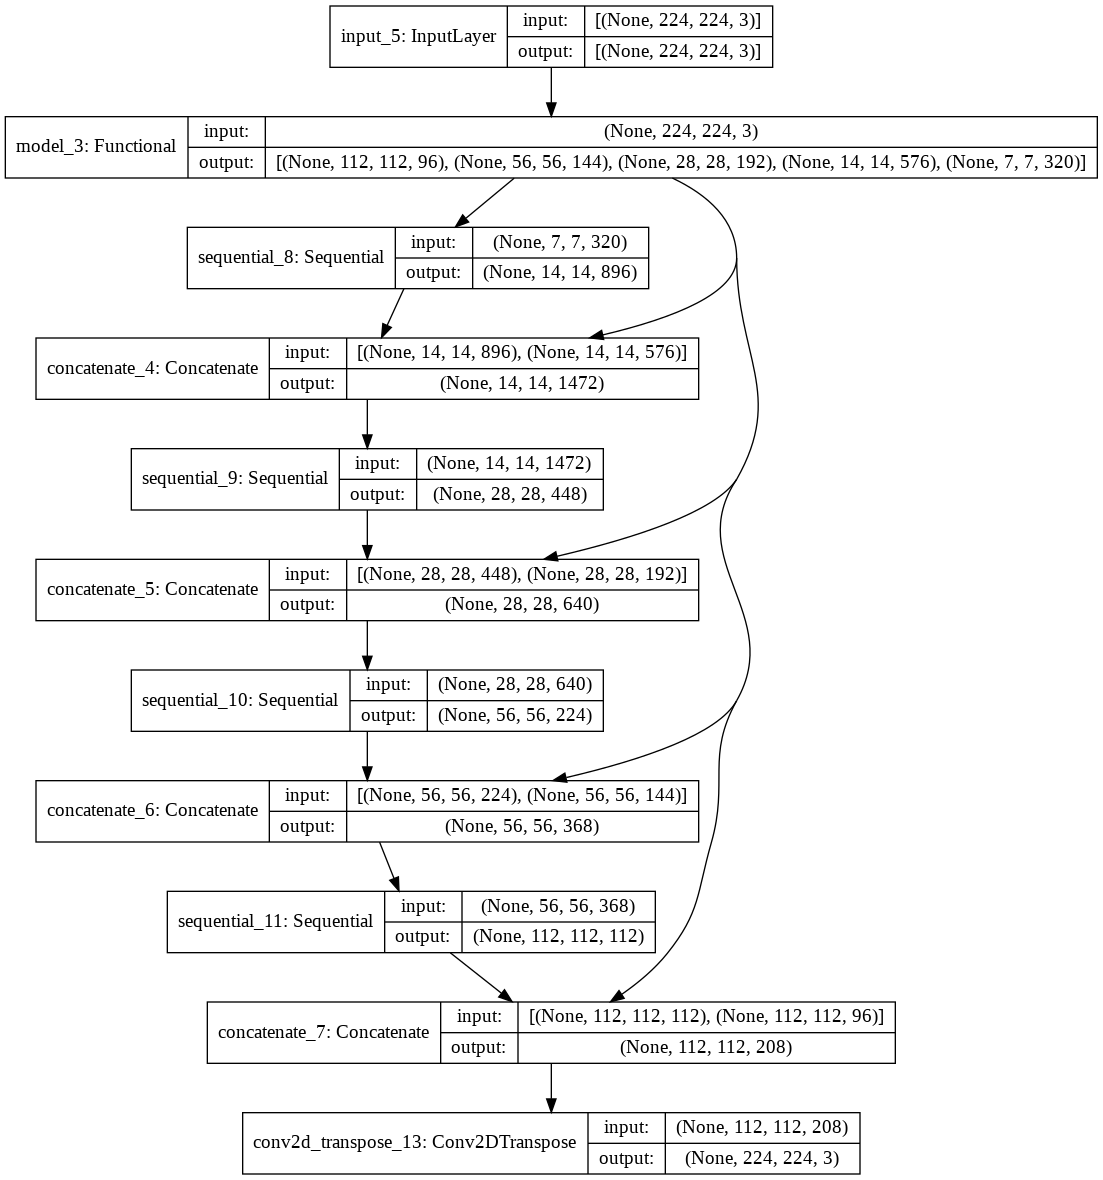

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.save("./drive/My Drive/Colab Notebooks/seg.hdf5")  

# Export model for tflite format

In [ ]:
model = tf.saved_model.load("./drive/My Drive/Colab Notebooks/seg2.hdf5")
# tf.saved_model.save(model, "./drive/My Drive/Colab Notebooks/seg2.hdf5")
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 224, 224, 3])
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

# Save the model.
with open('./drive/My Drive/Colab Notebooks/model.tflite', 'wb') as f:
  f.write(tflite_model)